# Clusterización de información de productos en función de características

## Importación de librerias necesarias

In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

def find_src_folder(current_path: Path, folder_name: str = 'src') -> Path:
    search_directories = [current_path] + list(current_path.parents)
    for parent in search_directories:
        if parent.name == folder_name:
            return parent.parent
    return current_path

src_path = find_src_folder(Path.cwd(), 'src')
sys.path.append(str(src_path))

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import pandas as pd

from matplotlib.ticker import FuncFormatter

import tensorflow_hub as hub

from sklearn.neighbors import NearestNeighbors

from langchain_ollama.embeddings import OllamaEmbeddings

from sklearn.cluster import DBSCAN

from src.utils import SparkUtils

2025-06-15 22:31:00.169618: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:31:00.511837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:31:00.835354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750044661.054416  109270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750044661.125479  109270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 22:31:01.749954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
spark_utils = SparkUtils()

your 131072x1 screen size is bogus. expect trouble
25/06/15 22:32:09 WARN Utils: Your hostname, ASUSPRIMEA520MAII resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/15 22:32:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/mnt/c/Users/User/Documents/Maestr%c3%ada/Amazon%20Reviews%20Code/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/edgar/.ivy2/cache
The jars for the packages stored in: /home/edgar/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b7cbc3b1-5d50-4fdd-a2ff-63339159acb9;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 192ms :: artifacts dl 7ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   

## Cargar modelo embedding (Llama3)

In [5]:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=es-419
MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load( MODULE_URL )

2025-06-15 22:32:22.250997: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Generar agrupación basada en título de primera cuantificación de item 

#### Cargar información de títulos

In [6]:
meta_items_pandas_sample = spark_utils.get_meta_items_sample( 10_000 )

In [7]:
sentences = meta_items_pandas_sample['title'].to_list()

In [8]:
embeddings_np = model( sentences )

In [9]:
embeddings_np.shape

TensorShape([10000, 512])

#### Agglomerative Clustering

In [10]:
N_AGGLOMERATIVE_CLUSTERS = 5

In [11]:
agg_model = AgglomerativeClustering(n_clusters=N_AGGLOMERATIVE_CLUSTERS, linkage='ward')
labels = agg_model.fit_predict(embeddings_np)

meta_items_pandas_sample['agg_cluster'] = labels

**Examinar agrupaciones resultado**

Examinar ejemplos de cada una de las agrupaciones generadas

In [12]:
for i in range( N_AGGLOMERATIVE_CLUSTERS ):
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['agg_cluster'] == i ][['title', 'agg_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,agg_cluster
0,Accupressure Guide,0
8,Ac Market tips,0
10,Piano Wizard Premier With 49E Keystation,0
15,Fat Dragons,0
16,TrainMania Lite,0
17,Line Rider,0
18,World Explorer,0
21,"New Coupons, Daily Deals and Freebies - Update...",0
23,London Transport Status,0
24,Soccer by Fawesome.tv,0


>>>>

>>>> Cluster 2


,title,agg_cluster
2,Mahjong 2015,1
6,My Aquarium - Hidden Object Challenge # 122,1
26,PlayHOG # 216 Hidden Object Games Free New - T...,1
67,2048 Drop n Merge Numbers: Match 3 Columns Puzzle,1
92,Crime Story - Hidden Witness in Dark Shadows,1
120,Mahjong Holiday Joy 2016,1
122,Wood Block Puzzle - Sudoku Woody Block Puzzles...,1
134,Beard Salon – Free Games for Kids.,1
137,Hidden Scenes - Mystery Mansion,1
145,Castle: The 3D Hidden Objects Adventure Game FREE,1


>>>>

>>>> Cluster 3


,title,agg_cluster
19,Corel PaintShop Pro X4 [Old Version],2
20,Que Publishing 0789738252 Power Excel 2007 wit...,2
42,TurboTax Deluxe 2014 Fed + State + Fed Efile T...,2
45,Microsoft Virtual PC for Mac 6.1 [Old Version],2
47,AutoCAD Freestyle [Old Version],2
48,Anime Studio Pro 9.5,2
54,Kaspersky Internet Security Multi-Device 2015 ...,2
60,MyScript Studio Notes Edition [Download],2
87,TurboTax Deluxe Fed 2022,2
88,"OVER 34,887 DESIGNS HUGE MEGA Vector Clipart V...",2


>>>>

>>>> Cluster 4


,title,agg_cluster
43,Dinosaurus,3
84,96.1BOBFM,3
91,NextView,3
100,LoanPayment,3
107,NewsWatch,3
109,aCheckbook+,3
161,WikiPedi,3
165,UniWar,3
271,BoxCast,3
299,RomaniaTvFREE,3


>>>>

>>>> Cluster 5


,title,agg_cluster
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,4
3,Jewels Brick Breakout,4
4,Traffic Police: Off-Road Cub,4
5,Shadow Fighting Superhero War,4
7,Giant Surprise Petcage! Unlock Superhero Puppy,4
9,Gem Shopping Network,4
11,Boxing Game 3D - Real Fighting,4
12,RoverCraft Race Your Space Car,4
13,HALLOWEEN MATCH 3 IN A ROW,4
14,For Rent: Haunted House,4


>>>>



#### DBScan Clustering

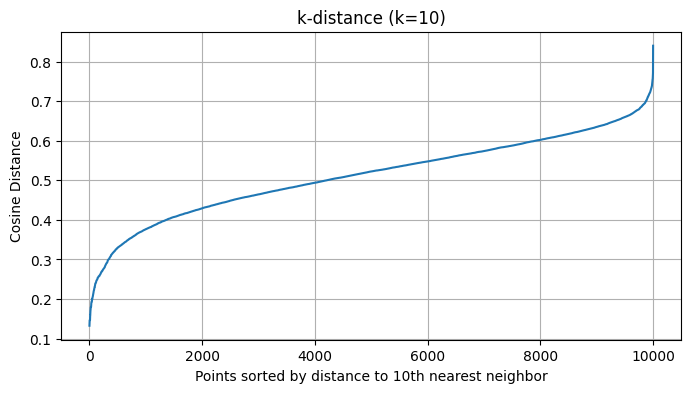

In [13]:
X = embeddings_np

neighbors = NearestNeighbors(n_neighbors=10, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

k_distances = np.sort(distances[:, 9])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance (k=10)")
plt.xlabel("Points sorted by distance to 10th nearest neighbor")
plt.ylabel("Cosine Distance")
plt.grid(True)
plt.show()

In [14]:
dbscan_model = DBSCAN(
    eps = 0.5,
    metric = 'cosine',
    min_samples = 10
)

In [15]:
meta_items_pandas_sample['dbscan_cluster'] = dbscan_model.fit_predict( embeddings_np )

In [16]:
dbscan_labels = set(dbscan_model.labels_)

In [17]:
for i in dbscan_labels:
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['dbscan_cluster'] == i ][['title', 'dbscan_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,dbscan_cluster
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,0
2,Mahjong 2015,0
3,Jewels Brick Breakout,0
4,Traffic Police: Off-Road Cub,0
5,Shadow Fighting Superhero War,0
6,My Aquarium - Hidden Object Challenge # 122,0
7,Giant Surprise Petcage! Unlock Superhero Puppy,0
9,Gem Shopping Network,0
10,Piano Wizard Premier With 49E Keystation,0
11,Boxing Game 3D - Real Fighting,0


>>>>

>>>> Cluster 2


,title,dbscan_cluster
95,FREE City Night Dream - decor your room with b...,1
1522,FREE Rainy Wonders HD - Enjoy the relaxing rai...,1
1594,FREE Decent Gas Fireplace HD - Enjoy the Coole...,1
2631,FREE Stone Fireplace Pack HD - Enjoy the Coole...,1
2920,FREE Fireplace Bricks HD - enjoy the winter Ch...,1
3960,FREE Motion Waterfall HD - Decorate your room ...,1
4531,"FREE Waterside Fireworks HD , Decor your celeb...",1
6258,FREE Green Rainfall HD - Relaxing Rainy Ambien...,1
6881,FREE Calm Moon Lights HD - Decorate your room ...,1
7341,FREE Bricks Fireplace HD - Enjoy the Cooled Ch...,1


>>>>

>>>> Cluster 3


,title,dbscan_cluster
224,A4C - Answers 4 Catholics,2
2050,Catholic Prayers,2
5369,Pray: The Catholic Novena App,2
6087,Huna Manifestation Prayer,2
6330,Prayer Times & Qibla,2
7074,My Prayer List,2
7366,Catholic Pocket Prayers,2
8086,Audio Catholic Prayer,2
8395,Catholic Daily Readings,2


>>>>

>>>> Cluster 4


,title,dbscan_cluster
731,Stop Nail Biting Hypnosis,3
764,Stop Panic & Anxiety Self-Help,3
1042,Chill Pill Hypnosis Session,3
2779,Past Life Regression Hypnosis,3
3556,Test Taking Anxiety Hypnosis,3
6228,Weight Loss Hypnosis,3
8153,Healing Hypnosis,3
9967,Build Self-Esteem Hypnosis FREE - Mindfulness ...,3


>>>>

>>>> Cluster 5


,title,dbscan_cluster
198,monBridge-BLE to WIFI Bridge,4
2169,ShareiFi - WiFi File Transfer,4
3324,WIFI File Sharing,4
4295,Android Wifi Data Transfer,4
4483,Hack WiFi Network,4
5416,Wi-Fi Monitor,4
6301,hack WIFI password pro simulator,4
8397,PeerDeviceNet(Full Edition) - Sharing over WiF...,4
9223,wifi hacker wps tools pro,4
9866,Wifi Device Sharing,4


>>>>

>>>> Cluster 6


,title,dbscan_cluster
378,Glide - Video Texting,5
529,Spam SMS Blocker,5
934,"Talk.to: Fast, Fun Texting",5
1564,On Second Thought- SMS,5
4749,SMS Sounds,5
5877,Text Friends App,5
8037,POWOW: Text Messaging,5
9962,SMS Sounds,5


>>>>

>>>> Cluster 0


,title,dbscan_cluster
0,Accupressure Guide,-1
8,Ac Market tips,-1
21,"New Coupons, Daily Deals and Freebies - Update...",-1
23,London Transport Status,-1
27,Schwab Advisor Center® Mobile,-1
28,How to Start a Boarding School Plus Business Plan,-1
31,Slugterra: Dark Waters,-1
32,Make Picture Slideshow,-1
34,iTransitBuddy DART,-1
36,Tether It,-1


>>>>



## Clusterización incluyendo descripciones

In [25]:
meta_items_pandas_sample_titles = meta_items_pandas_sample[['parent_asin', 'title']]

In [26]:
meta_items_pandas_sample_description_exp = meta_items_pandas_sample[['parent_asin', 'description']].explode('description')
meta_items_pandas_sample_description_exp['description'] = meta_items_pandas_sample_description_exp['description'].str.split(".")
meta_items_pandas_sample_description_exp = meta_items_pandas_sample_description_exp.explode('description')

In [44]:
meta_items_pandas_sample_texts = pd.concat([
    meta_items_pandas_sample_titles.rename( columns = {
        'parent_asin': 'id', 'title': 'sentence'
    }),
    meta_items_pandas_sample_description_exp.rename( columns = {
        'parent_asin': 'id', 'description': 'sentence'
    })
])

In [46]:
meta_items_pandas_sample_texts = meta_items_pandas_sample_texts[
    meta_items_pandas_sample_texts['sentence'].str.len() > 0
]

In [49]:
grouped_embeddings = model( meta_items_pandas_sample_texts['sentence'] )

In [53]:
meta_items_pandas_sample_texts['embeddings'] = list(grouped_embeddings.numpy())

In [55]:
meta_items_pandas_sample_texts_avg = (
    meta_items_pandas_sample_texts.groupby("id")["embeddings"]
    .apply(lambda vectors: np.mean(np.stack(vectors), axis=0))
    .reset_index()
)

In [59]:
avg_embeddings = np.vstack(meta_items_pandas_sample_texts_avg['embeddings'].values)

In [61]:
agg_model_avg = AgglomerativeClustering(n_clusters=N_AGGLOMERATIVE_CLUSTERS, linkage='ward')
labels = agg_model_avg.fit_predict(avg_embeddings)

meta_items_pandas_sample_texts_avg['agg_avg_cluster'] = labels

In [64]:
meta_items_pandas_sample_texts_avg_with_item_data = (
    meta_items_pandas_sample_texts_avg.merge(
        meta_items_pandas_sample, left_on = 'id', right_on = 'parent_asin'
    )
)

In [65]:
for i in range( N_AGGLOMERATIVE_CLUSTERS ):
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample_texts_avg_with_item_data[
        meta_items_pandas_sample_texts_avg_with_item_data['agg_avg_cluster'] == i
    ][['title', 'description', 'agg_avg_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,description,agg_avg_cluster
3,Type To Learn 3,[Students embark on zany time travel missions ...,0
6,Webassign College Physics,[],0
7,SOS 12th Grade Math - USB,[],0
8,Nolo's California Quick Corp: Incorporate Your...,[LeaseWriter Plus guides you through the creat...,0
9,Independent Paralegal's Handbook: How to Provi...,"[For over 25 years, more and more people have ...",0
10,"Editor in Chief: B1, Grades 6-8",[Features 3 levels of challenges with instruct...,0
12,Matlab 6 Release 12 with Simulink 4 Student Ve...,[Solve complex technical computing problems in...,0
16,Learn Lithuanian *Visual language learning* fo...,[This Lithuanian program is designed for your ...,0
18,Lab Mnl CD-Sci of Earth System,[],0
20,Made E-Z Deluxe Business Forms,[],0


>>>>

>>>> Cluster 2


,title,description,agg_avg_cluster
51,Jack 5.0 -- World Champion Computer Bridge -- ...,[],1
84,Oregon Trail II - Anniversary,[Original unopened collectors edition of Orego...,1
268,PANTONE COLOR CUE - 1 UNIT,[],1
354,Number Munchers,[Munch on Math! Help your Muncher avoid the mi...,1
364,Lego Island 2: The Brickster's Revenge (XP Com...,[[Ages 6 & Up] Save LEGO Island from the Brick...,1
496,Chess King with Houdini 2 Pro (DVD),[],1
596,Lottery,[],1
612,DK Little Polar Bear Take Me Home,[Based on the Children's book artist Hans De B...,1
672,Text Twist 2,[How good is YOUR vocabulary? Show off your kn...,1
740,Punch! Kitchen & Bath Designer,[],1


>>>>

>>>> Cluster 3


,title,description,agg_avg_cluster
0,Medstudy Video Board Review of InternalMedicin...,[No returns.],2
1,The Learning Company - Oregon Trail 5th Edition,"[Product description, Explore the West! Live t...",2
2,My Amazing Human Body,[Let Seemore Skinless teach your child about t...,2
11,Delorme Xmap 7 Professional With Topo & Street...,[Supports ESRI Shapefile format so you can dow...,2
13,My Wine Collection,"[brand new, still in package, excellent condit...",2
14,Cakewalk Sonar 4 Video Training Course,[Interactive video tutorials covering all aspe...,2
17,"Drugs, Society, and Human Behavior - Connect A...","[Drugs, Society, and Human Behavior - Connect ...",2
19,The Thomas Nelson Bible Study Library,[],2
23,Greek Tutor,[],2
28,Personal Ancestral File 5.2 (Includes Personal...,[One of the oldest and most popular genealogy ...,2


>>>>

>>>> Cluster 4


,title,description,agg_avg_cluster
4,Reader Rabbit Learn to Read with Phonics Presc...,[Preschool/Kindergarten Learning to read with ...,3
5,Leap Into Phonics Build Phonemic Awareness,"[Leap Into Phonics consists of 8 components, e...",3
15,Hair 900 DVD DEMO For Practice,[Vietnamese & English Bleach Color Relaxed Hai...,3
57,Jump Start Learning Games: ABC's,"[Amazon.com, In, JumpStart Learning Games: ABC...",3
58,JumpStart Preschool,"[Product description, Meet Casey Cat, Pierre P...",3
61,Where in the World Is Carmen Sandiego? [OLD VE...,"[Amazon.com, Discover the world in a thrilling...",3
62,I Spy Spooky Mansion,"[Product description, Lots of paths to choose ...",3
64,MatchBox Caterpillar Construction Zone CD & CA...,"[Amazon.com, Dig, demolish, construct, and sav...",3
69,My Type Artist,"[Amazon.com, MySoftware's MyTypeArtist is a gr...",3
83,Arthur's Teacher Trouble,[Arthur begins a new school year in his third ...,3


>>>>

>>>> Cluster 5


,title,description,agg_avg_cluster
283,"Animals: Amazing, Wild and Endangered Learning...",[3 Full-Featured Titles on 3 CD-ROMs! Product ...,4
291,How Many Bugs In A Box?,[],4
335,WeatherBug Plus,"[Product Description, WeatherBug Plus is your ...",4
378,Starry Night Complete Space & Astronomy Pack 2...,"[From the Manufacturer, If youre new to astron...",4
406,Marine Aquarium + Sharks,[Turn your monitor into the exotic fish tank y...,4
422,Switch Zoo Deluxe: Make New Animals! (Jewel Ca...,[Make your own new creatures at this photoreal...,4
425,Aqua Real 3D Deluxe,[Experience ultra realistic virtual fish in un...,4
441,Sid Meier's Colonization (Jewel Case),[Sid Meier's Colonization: Create a New Nation...,4
444,Game Empire (Over 250 Games!},"[* * * WITH OVER 250 GAMES ON A SINGLE CD, GAM...",4
475,Starry Night Pro Plus 6.2 [Old Version],"[Amazon.com, For the advanced amateur astronom...",4


>>>>

